In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from loader import *
from models import *
from utils import *
from plotting import *

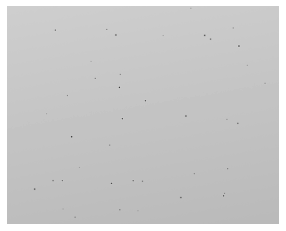

In [207]:

moving_prey = moving_spherical_plankton(im_size_height=512, 
                                            im_size_width=640, 
                                            radius=0.2e-6, 
                                            label=0, 
                                            diffusion_constant_coeff=1.3)

stationary_prey = stationary_spherical_plankton(im_size_height=512, 
                                                    im_size_width=640, 
                                                    radius=0.2e-6, 
                                                    label=-1)

moving_predator = moving_spherical_plankton(im_size_height=512, 
                                            im_size_width=640, 
                                            radius=0.3e-6, 
                                            label=1, 
                                            diffusion_constant_coeff=8)

stationary_predator = stationary_spherical_plankton(im_size_height=512, 
                                                    im_size_width=640, 
                                                    radius=0.3e-6, 
                                                    label=-1)


sequential_moving_prey = Sequential(moving_prey, position=get_position_moving_plankton)
sequential_stationary_prey = Sequential(stationary_prey, position=get_position_stationary_plankton)
sequential_moving_predator = Sequential(moving_predator, position=get_position_moving_plankton)
sequential_stationary_predator = Sequential(stationary_predator, position=get_position_stationary_plankton)

microscope = plankton_brightfield(im_size_height=512, 
                                  im_size_width=640, 
                                  gradient_amp=0.1)

no_of_moving_prey, no_of_stationary_prey, no_of_moving_predators, no_of_stationary_predators = 10, 10, 10, 10

# sample = create_sample(sequential_moving_predator, no_of_moving_predators,
#                        sequential_moving_prey, no_of_moving_prey, 
#                        sequential_stationary_prey, no_of_stationary_prey, 
#                        sequential_stationary_predator, no_of_stationary_predators) 


sample = sequential_moving_prey**no_of_moving_prey + sequential_stationary_prey**no_of_stationary_prey + sequential_moving_predator**no_of_moving_predators + sequential_stationary_predator**no_of_stationary_predators

noise_amp = 0.1
norm_min, norm_max= 0, 1
sequence = create_sequence(noise_amp, sample, microscope, norm_min, norm_max)

sequence_length = 2
imaged_particle_sequence = Sequence(sequence, sequence_length=sequence_length)

imaged_particle_sequence.plot(cmap='gray')

In [179]:
arg=[sequential_moving_predator, no_of_moving_predators,
     sequential_moving_prey, no_of_moving_prey, 
     sequential_stationary_prey, no_of_stationary_prey, 
     sequential_stationary_predator, no_of_stationary_predators]


no_of_plankton = lambda: np.random.randint(int(arg[1]*0.66), int(arg[1]*1.33))
sample = arg[0]**no_of_plankton
for i in range(2, len(arg), 2):
    no_of_plankton = lambda: np.random.randint(int(arg[i+1]*0.66), int(arg[i+1]*1.33))
    sample = Branch(sample, arg[i]**no_of_plankton)

In [202]:
sample = sequential_moving_prey**no_of_moving_prey 
sample +=  sequential_stationary_prey**no_of_stationary_prey
sample += sequential_moving_predator**no_of_moving_predators 
sample += sequential_stationary_predator**no_of_stationary_predators

In [200]:
sample = Branch(sequential_moving_prey**no_of_moving_prey, sequential_stationary_prey**no_of_stationary_prey)
sample = Branch(sample, sequential_moving_predator**no_of_moving_predators)
sample = Branch(sample, sequential_stationary_predator**no_of_stationary_predators)

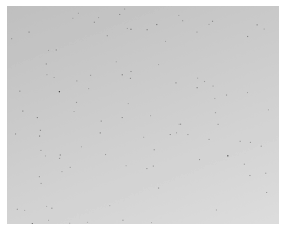

In [203]:
noise_amp = 0.1
norm_min, norm_max= 0, 1
sequence = create_sequence(noise_amp, sample, microscope, norm_min, norm_max)

sequence_length = 2
imaged_particle_sequence = Sequence(sequence, sequence_length=sequence_length)

imaged_particle_sequence.plot(cmap='gray')

2
2


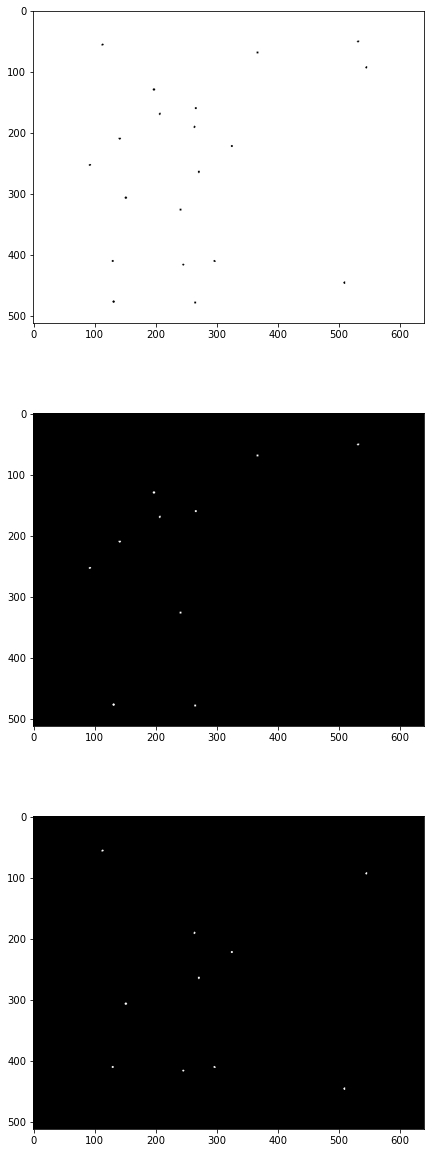

In [210]:
label = get_target_sequence(im_seq)
label_function = get_target_sequence
plot_label(label_function, imaged_particle_sequence)

In [ ]:
batch_function = create_custom_batch_function(imaged_particle_sequence, 
                                              outputs=[[0,1], 0, 1], 
                                              function_img=[Normalize_image],
                                              function_diff=[Normalize_image])


train_images = batch_function(imaged_particle_sequence.resolve())

plot_batch(train_images)

In [ ]:
from deeptrack.generators import ContinuousGenerator
generator = ContinuousGenerator(
    imaged_particle_sequence,
    get_target_sequence,
    batch_function,
    batch_size=8,
    min_data_size=80,
    max_data_size=512
    )

In [ ]:
model = generate_unet(im_size_height=512, 
                      im_size_width=640, 
                      no_of_inputs=3, 
                      no_of_outputs=3)

In [ ]:
model = train_model_early_stopping(model, 
                                   generator, 
                                   patience=10, 
                                   epochs=100, 
                                   steps_per_epoch=10)

In [ ]:
# change outputs
folder_path = 'E:\\Documents\\Anaconda\\Jupyterkod\\Exjobb\\Egen kod\\Exjobb\\Test simulations\\raw_output\\raw_output_images'
im_stack = get_image_stack(
    outputs=[[0,1], 0, 1], 
    folder_path=folder_path, 
    frame_im0=0, 
    im_size_width=640, 
    im_size_height=512,
    im_resize_width=640, 
    im_resize_height=512,
    function_img=[Normalize_image],
    function_diff=[Normalize_image])

# plot_im_stack(im_stack)
# plot_prediction(model=model, im_stack=im_stack)
plt.imshow(model.predict(im_stack)[0,:,:,1], cmap='gray')

In [ ]:
positions = extract_positions(
    no_of_frames=49, 
    outputs=[[0,1]], 
    folder_path=folder_path, 
    frame_im0=0, 
    im_size_width=640, 
    im_size_height=512,
    im_resize_width=640, 
    im_resize_height=512,
    model=model, 
    layer=2, 
    value_threshold=0.6,
    function_img=[Normalize_image],
    function_diff=[Normalize_image])


In [ ]:
list_of_plankton = assign_positions_to_planktons(positions, max_dist=10, threshold = 5, extrapolate=True)
list_of_plankton = Interpolate_gaps_in_plankton_positions(list_of_plankton=list_of_plankton)
list_of_plankton = Trim_list_from_stationary_planktons(list_of_plankton=list_of_plankton, min_distance=25)

plankton_track, plankton_dont_track = split_plankton(percentage_threshold=0.2, list_of_plankton=list_of_plankton)

In [ ]:
plot_and_save_track(no_of_frames=49,
                    plankton_track=plankton_track,
                    plankton_dont_track=plankton_dont_track,
                    folder_path=folder_path,
                    frame_im0=1,
                    save_images=1,
                    show_plankton_track = True,
                    show_plankton_dont_track = 0,
                    show_numbers_track = 0,
                    show_numbers_dont_track = 0,
                    show_numbers_specific_plankton = False,
                    show_specific_plankton = False,
                    specific_plankton = None,
                    color_plankton_track = 'b',
                    color_plankton_dont_track = 'r',
                    color_specific_plankton = 'w',
                    save_path = 'E:\\Documents\\Anaconda\\Jupyterkod\\Exjobb\\Egen kod\\Exjobb\\New imulations\\Raw_output',
                    frame_name = 'track',
                    file_type = '.jpg')

In [ ]:
Make_video(frame_im0=0,
           folder_path='E:\\Documents\\Anaconda\\Jupyterkod\\Exjobb\\Egen kod\\Exjobb\\New imulations\\Raw_output', 
           save_path='E:\\Documents\\Anaconda\\Jupyterkod\\Exjobb\\Egen kod\\Exjobb\\New imulations\\Test_video.avi', 
           fps=7, 
           no_of_frames=49)

In [ ]:
save_path_model = 'E:\\Documents\\Anaconda\\Jupyterkod\\Exjobb\\Egen kod\\Exjobb\\New imulations\\Raw_output\\models\\diff01.keras'
model.save(save_path_model)